# TM10007 Assignment

In [9]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Create training and test set

In [10]:
"""
from sklearn.model_selection import train_test_split
from load_data import load_data

# Code used to load the original data and split into train and test set
# Was only run once at the start to create test and train dataset

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

print(data.info())

train_data, test_data = train_test_split(data, test_size=0.2)

train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)
"""

"\nfrom sklearn.model_selection import train_test_split\nfrom load_data import load_data\n\n# Code used to load the original data and split into train and test set\n# Was only run once at the start to create test and train dataset\n\ndata = load_data()\nprint(f'The number of samples: {len(data.index)}')\nprint(f'The number of columns: {len(data.columns)}')\n\nprint(data.info())\n\ntrain_data, test_data = train_test_split(data, test_size=0.2)\n\ntrain_data.to_csv('train_data.csv', index=False)\ntest_data.to_csv('test_data.csv', index=False)\n"

## Data loading

In [ ]:
# Data loading functions. Uncomment the one you want to use

import pandas as pd

train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

print(len(train_data[train_data['label'] == 'GIST']))
print(len(test_data[test_data['label'] == 'GIST']))


101
24


## Feature selection and dimension reduction

In [ ]:
training_labels = train_data['label']
training_values = train_data.drop(columns=['label'], axis=1)

# First we remove NaNs by averaging
training_values = training_values.fillna(training_values.mean())

# First we remove features with 0 variance
print(training_values.shape)

print(f'We removed {training_values.loc[:, training_values.var() == 0].shape[1]} columns without any variance')
training_values = training_values.loc[:, training_values.var() != 0]

print(training_values.shape)

# ADD: remove NaNs by averaging & standardizing



(196, 493)
We removed 9 columns without any variance
(196, 484)


## Random forest

Cross-validation scores: [0.5        0.55       0.65       0.6        0.7        0.65
 0.63157895 0.73684211 0.52631579 0.52631579]
Mean cross-validation score: 0.6071052631578947
                                               Feature  Importance
241  PREDICT_original_tf_GLCMMS_correlationd1.0A0.0std    0.000000
289         PREDICT_original_tf_Gabor_peak_F0.05_A1.57    0.000000
284         PREDICT_original_tf_Gabor_mean_F0.05_A1.57    0.000000
283          PREDICT_original_tf_Gabor_max_F0.05_A1.57    0.000000
282          PREDICT_original_tf_Gabor_min_F0.05_A1.57    0.000000
..                                                 ...         ...
349          PREDICT_original_tf_Gabor_mean_F0.2_A2.36    0.015544
24                             PREDICT_original_hf_min    0.016184
14               PREDICT_original_sf_solidity_avg_2.5D    0.016656
298       PREDICT_original_tf_Gabor_median_F0.05_A2.36    0.023364
357        PREDICT_original_tf_Gabor_energy_F0.2_A2.36    0.024139

[484 rows x 2 c

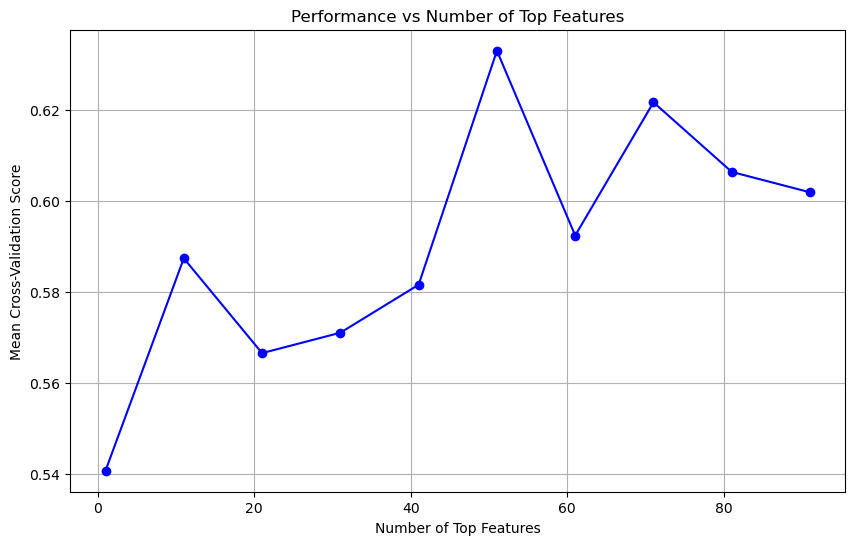

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=20,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=5,
    random_state=42
)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, training_values, training_labels, cv=10)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

trained_model = rf_model.fit(training_values, training_labels)

feature_importances = trained_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': training_values.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

print(feature_importance_df)

performances = []

for top_n in range(1, 100, 10):
    top_features = feature_importance_df.head(top_n)['Feature'].values

    print(top_features)
    data_selected = training_values[top_features]
    labels_selected = training_labels

    # Reduce dataset to selected features
    #values_selected = training_values[:, selected_features]
    cv_scores_new = cross_val_score(rf_model, data_selected, labels_selected, cv=10)
    print("New ross-validation scores:", cv_scores_new)
    print("Mean cross-validation score:", cv_scores_new.mean())

    performances.append(cv_scores_new.mean())

import matplotlib.pyplot as plt

# Plot the performances
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100, 10), performances, marker='o', linestyle='-', color='b')
plt.title('Performance vs Number of Top Features')
plt.xlabel('Number of Top Features')
plt.ylabel('Mean Cross-Validation Score')
plt.grid(True)
plt.show()

# Make learning curves
# Maybe add generalization
# VOorkeur voor random search